#### Импорт библиотек и подготовка ноутбука

In [1]:
# Стандартные библиотеки
import os
from datetime import datetime
import time
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

# Базовые библиотеки
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import pandas as pd

# PyTorch и связанные библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, SGD

# Huggingface transformers и datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    get_scheduler,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction
)

from datasets import load_dataset

# Метрики и оценка
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    f1_score
)

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
RANDOM_SEED = 777

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# 0. Подготовка и загрузка данных

In [4]:
# Замер использования GPU памяти
def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 2)  # в МБ
    return 0

# Функция для загрузки датасета
def load_dataset_and_model(model_name="google-bert/bert-base-uncased"):
    dataset = load_dataset("dair-ai/emotion")
    print(f"Датасет загружен: {dataset}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Определяем метки эмоций
    emotions = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

    # Выводим информацию о датасете
    print(f"Train samples: {len(dataset['train'])}")
    print(f"Test samples: {len(dataset['test'])}")
    print(f"Emotions: {emotions}")

    return dataset, tokenizer, emotions

# Токенизация датасета
def prepare_dataset(dataset, tokenizer, max_length=128):
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    tokenized_dataset.set_format("torch")

    return tokenized_dataset


def create_dataloaders(tokenized_dataset, tokenizer, batch_size=16):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_dataloader = DataLoader(
        tokenized_dataset["train"],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    eval_dataloader = DataLoader(
        tokenized_dataset["test"],
        batch_size=batch_size,
        collate_fn=data_collator
    )

    return train_dataloader, eval_dataloader

# Оценка модели
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(predictions)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Подсчет параметров модели
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "frozen_params": total_params - trainable_params,
        "trainable_params_percent": 100 * trainable_params / total_params
    }

# 1. Full finetuning

In [5]:

# Функция обучения модели в режиме full finetuning
def train_full_finetuning(model, train_dataloader, eval_dataloader, num_epochs, device):
    # Оптимизатор
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Scheduler
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Измерение начальной памяти
    initial_memory = get_gpu_memory()

    # Обучение
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_dataloader)

        # Оценка на тестовом наборе
        eval_metrics = evaluate_model(model, eval_dataloader, device)

        print(f"Эпоха {epoch+1}/{num_epochs}:")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"  F1 Score: {eval_metrics['f1']:.4f}")

    training_time = time.time() - start_time
    max_memory = get_gpu_memory() - initial_memory
    
    param_stats = count_parameters(model)

    return {
        "metrics": evaluate_model(model, eval_dataloader, device),
        "training_time": training_time,
        "memory_usage": max_memory,
        **param_stats
    }

In [6]:
# Настройки
model_name = "google-bert/bert-base-uncased"
num_epochs = 3
batch_size = 16
max_length = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Используем устройство: {device}")

# Этап 1: Загрузка датасета и модели
print("\n--- Этап 1: Загрузка датасета и модели ---")

# Загрузка датасета
dataset = load_dataset("dair-ai/emotion")
print(f"Датасет загружен: {dataset}")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Токенизация датасета
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

print(f"Токенизированный датасет: {tokenized_dataset}")

# Создание DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=batch_size,
    collate_fn=data_collator
)

# Загрузка предобученной модели
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(dataset["train"].features["label"].names)
)
model.to(device)

# Оценка базовых метрик перед обучением
print("\nОценка базовых метрик перед обучением:")
baseline_metrics = evaluate_model(model, eval_dataloader, device)
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall: {baseline_metrics['recall']:.4f}")
print(f"F1 Score: {baseline_metrics['f1']:.4f}")

# Этап 2: Обучение модели в режиме full finetuning
print("\n--- Этап 2: Обучение модели в режиме full finetuning ---")

# Запускаем full finetuning
full_finetuning_results = train_full_finetuning(
    model, train_dataloader, eval_dataloader, num_epochs, device
)

print("\n--- Результаты full finetuning ---")
print(f"Качество классификации:")
print(f"  Accuracy: {full_finetuning_results['metrics']['accuracy']:.4f}")
print(f"  Precision: {full_finetuning_results['metrics']['precision']:.4f}")
print(f"  Recall: {full_finetuning_results['metrics']['recall']:.4f}")
print(f"  F1 Score: {full_finetuning_results['metrics']['f1']:.4f}")
print(f"Время обучения: {full_finetuning_results['training_time']:.2f} секунд")
print(f"Использование памяти: {full_finetuning_results['memory_usage']:.2f} МБ")
print(f"Общее количество параметров: {full_finetuning_results['total_params']:,}")
print(f"Количество обучаемых параметров: {full_finetuning_results['trainable_params']:,}")

Используем устройство: cuda:0

--- Этап 1: Загрузка датасета и модели ---
Датасет загружен: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
Токенизированный датасет: DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Оценка базовых метрик перед обучением:
Accuracy: 0.2765
Precision: 0.1786
Recall: 0.2765
F1 Score: 0.1689

--- Этап 2: Обучение модели в режиме full finetuning ---


Эпоха 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.50it/s]


Эпоха 1/3:
  Loss: 0.4696
  Accuracy: 0.9220
  F1 Score: 0.9224


Эпоха 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.48it/s]


Эпоха 2/3:
  Loss: 0.1305
  Accuracy: 0.9285
  F1 Score: 0.9280


Эпоха 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.50it/s]


Эпоха 3/3:
  Loss: 0.0907
  Accuracy: 0.9280
  F1 Score: 0.9281

--- Результаты full finetuning ---
Качество классификации:
  Accuracy: 0.9280
  Precision: 0.9290
  Recall: 0.9280
  F1 Score: 0.9281
Время обучения: 367.54 секунд
Использование памяти: 846.15 МБ
Общее количество параметров: 109,486,854
Количество обучаемых параметров: 109,486,854


# 2. Обучение в режиме linear probing с кастомной классификационной головой

In [7]:
# Кастомная классификационная голова для linear probing
class CustomClassificationHead(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels, dropout_prob=0.1):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.layernorm(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

# Модель с кастомной головой для классификации эмоций
class BertForEmotionClassification(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, hidden_size=None):
        super().__init__()
        # Загружаем базовую модель
        self.bert = AutoModel.from_pretrained(pretrained_model_name)

        # Замораживаем параметры базовой модели
        for param in self.bert.parameters():
            param.requires_grad = False

        # Определяем размеры для классификационной головы
        bert_hidden_size = self.bert.config.hidden_size
        if hidden_size is None:
            hidden_size = bert_hidden_size // 2

        # Создаем кастомную классификационную голову
        self.classifier = CustomClassificationHead(
            input_size=bert_hidden_size,
            hidden_size=hidden_size,
            num_labels=num_labels,
            dropout_prob=0.1
        )

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        # Получаем выходы базовой модели
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Используем [CLS] токен для классификации
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Пропускаем через классификационную голову
        logits = self.classifier(pooled_output)

        # Вычисляем потери, если предоставлены метки
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return type('ModelOutput', (), {
            'loss': loss,
            'logits': logits
        })

# Функция обучения модели в режиме linear probing
def train_linear_probing(model, train_dataloader, eval_dataloader, num_epochs, device, learning_rate=1e-3):
    # Оптимизатор (только для параметров классификационной головы)
    optimizer = AdamW(model.classifier.parameters(), lr=learning_rate)

    # Scheduler
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Измерение начальной памяти
    initial_memory = get_gpu_memory()

    # Обучение
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_dataloader)

        # Оценка на тестовом наборе
        eval_metrics = evaluate_model(model, eval_dataloader, device)

        print(f"Эпоха {epoch+1}/{num_epochs}:")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"  F1 Score: {eval_metrics['f1']:.4f}")

    training_time = time.time() - start_time
    max_memory = get_gpu_memory() - initial_memory
    
    param_stats = count_parameters(model)

    return {
        "metrics": evaluate_model(model, eval_dataloader, device),
        "training_time": training_time,
        "memory_usage": max_memory,
        **param_stats
    }

In [8]:
# Настройки
model_name = "google-bert/bert-base-uncased"
num_epochs = 3
batch_size = 16
max_length = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Используем устройство: {device}")

# Загрузка датасета
dataset = load_dataset("dair-ai/emotion")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Токенизация датасета
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Создание DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=batch_size,
    collate_fn=data_collator
)

print("\n--- Этап 3: Обучение модели в режиме linear probing ---")

# Создаем модель с кастомной классификационной головой
model = BertForEmotionClassification(
    pretrained_model_name=model_name,
    num_labels=len(dataset["train"].features["label"].names),
    hidden_size=384  # Используем половину от оригинального размера скрытого состояния BERT
).to(device)

# Оценка базовых метрик перед обучением
print("\nОценка базовых метрик перед обучением:")
baseline_metrics = evaluate_model(model, eval_dataloader, device)
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall: {baseline_metrics['recall']:.4f}")
print(f"F1 Score: {baseline_metrics['f1']:.4f}")

# Описание архитектуры кастомной головы
print("\nОписание кастомной классификационной головы:")
print("  1. Входной размер: 768 (размер выходного вектора BERT)")
print("  2. Скрытый слой: 384 нейрона с GELU активацией и LayerNorm")
print("  3. Выходной слой: 6 нейронов (по числу классов эмоций)")
print("  4. Dropout для регуляризации (p=0.1)")
print("\nОбоснование устройства головы:")
print("  - Использование промежуточного слоя позволяет снизить размерность и выделить более")
print("    релевантные признаки для задачи классификации эмоций")
print("  - GELU активация эффективно работает на задачах NLP и используется в архитектуре BERT")
print("  - LayerNorm стабилизирует обучение и помогает сети лучше обобщать данные")
print("  - Dropout предотвращает переобучение на обучающей выборке")

# Запускаем linear probing
linear_probing_results = train_linear_probing(
    model, train_dataloader, eval_dataloader, num_epochs, device
)

print("\n--- Результаты linear probing ---")
print(f"Качество классификации:")
print(f"  Accuracy: {linear_probing_results['metrics']['accuracy']:.4f}")
print(f"  Precision: {linear_probing_results['metrics']['precision']:.4f}")
print(f"  Recall: {linear_probing_results['metrics']['recall']:.4f}")
print(f"  F1 Score: {linear_probing_results['metrics']['f1']:.4f}")
print(f"Время обучения: {linear_probing_results['training_time']:.2f} секунд")
print(f"Использование памяти: {linear_probing_results['memory_usage']:.2f} МБ")
print(f"Количество обучаемых параметров: {linear_probing_results['trainable_params']:,}")
print(f"Количество замороженных параметров: {linear_probing_results['frozen_params']:,}")
print(f"Всего параметров: {linear_probing_results['total_params']:,}")

Используем устройство: cuda:0

--- Этап 3: Обучение модели в режиме linear probing ---

Оценка базовых метрик перед обучением:
Accuracy: 0.2050
Precision: 0.2334
Recall: 0.2050
F1 Score: 0.2111

Описание кастомной классификационной головы:
  1. Входной размер: 768 (размер выходного вектора BERT)
  2. Скрытый слой: 384 нейрона с GELU активацией и LayerNorm
  3. Выходной слой: 6 нейронов (по числу классов эмоций)
  4. Dropout для регуляризации (p=0.1)

Обоснование устройства головы:
  - Использование промежуточного слоя позволяет снизить размерность и выделить более
    релевантные признаки для задачи классификации эмоций
  - GELU активация эффективно работает на задачах NLP и используется в архитектуре BERT
  - LayerNorm стабилизирует обучение и помогает сети лучше обобщать данные
  - Dropout предотвращает переобучение на обучающей выборке


Эпоха 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.52it/s]


Эпоха 1/3:
  Loss: 1.3279
  Accuracy: 0.5475
  F1 Score: 0.4842


Эпоха 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.71it/s]


Эпоха 2/3:
  Loss: 1.2115
  Accuracy: 0.5825
  F1 Score: 0.5405


Эпоха 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.74it/s]


Эпоха 3/3:
  Loss: 1.1723
  Accuracy: 0.5925
  F1 Score: 0.5585

--- Результаты linear probing ---
Качество классификации:
  Accuracy: 0.5925
  Precision: 0.5871
  Recall: 0.5925
  F1 Score: 0.5585
Время обучения: 135.92 секунд
Использование памяти: 4.09 МБ
Количество обучаемых параметров: 298,374
Количество замороженных параметров: 109,482,240
Всего параметров: 109,780,614


# 3. Обучение модели в режиме PEFT с использованием prompt tuning или prefix tuning

In [9]:
from peft import (
    get_peft_model,
    PromptTuningConfig,
    TaskType,
    PrefixTuningConfig,
    LoraConfig
)

# Функция обучения модели с PEFT
def train_peft_model(model, train_dataloader, eval_dataloader, num_epochs, device, learning_rate=5e-4):
    # Оптимизатор (только для обучаемых параметров)
    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate
    )

    # Scheduler
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Измерение начальной памяти
    initial_memory = get_gpu_memory()

    # Обучение
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_dataloader)

        # Оценка на тестовом наборе
        eval_metrics = evaluate_model(model, eval_dataloader, device)

        print(f"Эпоха {epoch+1}/{num_epochs}:")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"  F1 Score: {eval_metrics['f1']:.4f}")

    training_time = time.time() - start_time
    max_memory = get_gpu_memory() - initial_memory
    
    param_stats = count_parameters(model)

    return {
        "metrics": evaluate_model(model, eval_dataloader, device),
        "training_time": training_time,
        "memory_usage": max_memory,
        **param_stats
    }

# Функция для создания модели с LoRA
def create_peft_model_lora(model_name, num_labels, device, lora_rank=8, lora_alpha=16, lora_dropout=0.1):
    # Загружаем базовую модель
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    # Настраиваем конфигурацию LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_rank,  # ранг LoRA
        lora_alpha=lora_alpha,  # параметр масштабирования
        lora_dropout=lora_dropout,  # dropout
        bias="none",
        # Указываем, к каким слоям применять LoRA
        target_modules=["query", "key", "value"]
    )

    # Применяем LoRA к модели
    model = get_peft_model(model, peft_config).to(device)

    return model

In [10]:
# Настройки
model_name = "google-bert/bert-base-uncased"
num_epochs = 3
batch_size = 16
max_length = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Гиперпараметры LoRA
lora_rank = 8  # ранг матриц LoRA
lora_alpha = 16  # параметр масштабирования
lora_dropout = 0.1  # dropout

print(f"Используем устройство: {device}")

# Загрузка датасета
dataset = load_dataset("dair-ai/emotion")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Токенизация датасета
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Создание DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=batch_size,
    collate_fn=data_collator
)

print("\n--- Этап 4: Обучение модели с PEFT (LoRA) ---")

# Создаем модель с PEFT (LoRA)
model = create_peft_model_lora(
    model_name=model_name,
    num_labels=len(dataset["train"].features["label"].names),
    device=device,
    lora_rank=lora_rank,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout
)

# Оценка базовых метрик перед обучением
print("\nОценка базовых метрик перед обучением:")
baseline_metrics = evaluate_model(model, eval_dataloader, device)
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall: {baseline_metrics['recall']:.4f}")
print(f"F1 Score: {baseline_metrics['f1']:.4f}")

# Описание LoRA
print("\nОписание PEFT с использованием LoRA:")
print(f"  Ранг LoRA: {lora_rank}")
print(f"  Параметр масштабирования (alpha): {lora_alpha}")
print(f"  Dropout: {lora_dropout}")
print("  Целевые модули: query, key, value матрицы в слоях внимания")
print("\nОбоснование выбора LoRA:")
print("  - LoRA эффективно снижает количество обучаемых параметров, добавляя")
print("    низкоранговые матрицы к весам слоев внимания")
print("  - Rank={lora_rank} обеспечивает хороший баланс между размером модели и ее выразительностью")
print("  - LoRA более эффективен с точки зрения памяти, чем полное дообучение")
print("  - Применение LoRA только к матрицам внимания сокращает количество обучаемых параметров")
print("    при сохранении высокого качества классификации")

# Запускаем обучение с PEFT
peft_results = train_peft_model(
    model, train_dataloader, eval_dataloader, num_epochs, device
)

print("\n--- Результаты PEFT с LoRA ---")
print(f"Качество классификации:")
print(f"  Accuracy: {peft_results['metrics']['accuracy']:.4f}")
print(f"  Precision: {peft_results['metrics']['precision']:.4f}")
print(f"  Recall: {peft_results['metrics']['recall']:.4f}")
print(f"  F1 Score: {peft_results['metrics']['f1']:.4f}")
print(f"Время обучения: {peft_results['training_time']:.2f} секунд")
print(f"Использование памяти: {peft_results['memory_usage']:.2f} МБ")
print(f"Количество обучаемых параметров: {peft_results['trainable_params']:,}")
print(f"Количество замороженных параметров: {peft_results['frozen_params']:,}")
print(f"Всего параметров: {peft_results['total_params']:,}")

Используем устройство: cuda:0

--- Этап 4: Обучение модели с PEFT (LoRA) ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Оценка базовых метрик перед обучением:
Accuracy: 0.1095
Precision: 0.0161
Recall: 0.1095
F1 Score: 0.0241

Описание PEFT с использованием LoRA:
  Ранг LoRA: 8
  Параметр масштабирования (alpha): 16
  Dropout: 0.1
  Целевые модули: query, key, value матрицы в слоях внимания

Обоснование выбора LoRA:
  - LoRA эффективно снижает количество обучаемых параметров, добавляя
    низкоранговые матрицы к весам слоев внимания
  - Rank={lora_rank} обеспечивает хороший баланс между размером модели и ее выразительностью
  - LoRA более эффективен с точки зрения памяти, чем полное дообучение
  - Применение LoRA только к матрицам внимания сокращает количество обучаемых параметров
    при сохранении высокого качества классификации


Эпоха 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 12.03it/s]


Эпоха 1/3:
  Loss: 0.7630
  Accuracy: 0.8980
  F1 Score: 0.8999


Эпоха 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.97it/s]


Эпоха 2/3:
  Loss: 0.2440
  Accuracy: 0.9150
  F1 Score: 0.9163


Эпоха 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.99it/s]


Эпоха 3/3:
  Loss: 0.1674
  Accuracy: 0.9260
  F1 Score: 0.9267

--- Результаты PEFT с LoRA ---
Качество классификации:
  Accuracy: 0.9260
  Precision: 0.9281
  Recall: 0.9260
  F1 Score: 0.9267
Время обучения: 265.36 секунд
Использование памяти: 3.46 МБ
Количество обучаемых параметров: 446,982
Количество замороженных параметров: 109,486,854
Всего параметров: 109,933,836


# 4. Обучение модели в режиме PEFT с использованием LoRA, подбирая оптимальный ранг

In [11]:
def train_peft_model_w_history(model, train_dataloader, eval_dataloader, num_epochs, device, learning_rate=5e-4):
    # Оптимизатор (только для обучаемых параметров)
    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate
    )

    # Scheduler
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Измерение начальной памяти
    initial_memory = get_gpu_memory()

    # Обучение
    start_time = time.time()

    # Сохраняем историю метрик для графиков
    history = {
        "loss": [],
        "accuracy": [],
        "f1": []
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_dataloader)
        history["loss"].append(avg_loss)

        # Оценка на тестовом наборе
        eval_metrics = evaluate_model(model, eval_dataloader, device)
        history["accuracy"].append(eval_metrics["accuracy"])
        history["f1"].append(eval_metrics["f1"])

        print(f"Эпоха {epoch+1}/{num_epochs}:")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"  F1 Score: {eval_metrics['f1']:.4f}")

    training_time = time.time() - start_time
    max_memory = get_gpu_memory() - initial_memory
    
    param_stats = count_parameters(model)

    return {
        "metrics": evaluate_model(model, eval_dataloader, device),
        "training_time": training_time,
        "memory_usage": max_memory,
        "history": history,
        **param_stats
    }

# Функция для экспериментов с разными рангами LoRA
def experiment_with_lora_ranks(
        model_name,
        num_labels,
        train_dataloader,
        eval_dataloader,
        device,
        ranks_to_try=[2, 4, 8, 16, 32],
        num_epochs=2
    ):
    results = {}

    for rank in ranks_to_try:
        print(f"\n--- Эксперимент с рангом LoRA = {rank} ---")

        # Создаем модель с текущим рангом LoRA
        model = create_peft_model_lora(
            model_name=model_name,
            num_labels=num_labels,
            device=device,
            lora_rank=rank
        )

        # Обучаем модель
        train_results = train_peft_model_w_history(
            model=model,
            train_dataloader=train_dataloader,
            eval_dataloader=eval_dataloader,
            num_epochs=num_epochs,
            device=device
        )

        # Сохраняем результаты
        results[rank] = {
            **train_results
        }

        print(f"Результаты для ранга {rank}:")
        print(f"  Accuracy: {train_results['metrics']['accuracy']:.4f}")
        print(f"  F1 Score: {train_results['metrics']['f1']:.4f}")
        print(f"  Время обучения: {train_results['training_time']:.2f} секунд")
        print(f"  Использование памяти: {train_results['memory_usage']:.2f} МБ")
        print(f"  Количество обучаемых параметров: {train_results['trainable_params']:.2f} МБ")
        print(f"  Количество замороженных параметров: {train_results['frozen_params']:.2f} МБ")
        print(f"  Всего параметров: {train_results['total_params']:.2f} МБ")

    return results

# Визуализация результатов экспериментов
def visualize_rank_experiments(results):
    ranks = list(results.keys())

    # График зависимости метрик от ранга
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(ranks, [results[rank]["metrics"]["accuracy"] for rank in ranks], marker='o')
    plt.xlabel('Ранг LoRA')
    plt.ylabel('Accuracy')
    plt.title('Зависимость Accuracy от ранга LoRA')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(ranks, [results[rank]["metrics"]["f1"] for rank in ranks], marker='o', color='orange')
    plt.xlabel('Ранг LoRA')
    plt.ylabel('F1 Score')
    plt.title('Зависимость F1 Score от ранга LoRA')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(ranks, [results[rank]["training_time"] for rank in ranks], marker='o', color='green')
    plt.xlabel('Ранг LoRA')
    plt.ylabel('Время обучения (сек)')
    plt.title('Зависимость времени обучения от ранга LoRA')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ranks, [results[rank]["trainable_params"] for rank in ranks], marker='o', color='red')
    plt.xlabel('Ранг LoRA')
    plt.ylabel('Количество обучаемых параметров')
    plt.title('Зависимость количества параметров от ранга LoRA')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('lora_rank_exps.png')
    plt.close()

    print("График сохранен в файл 'lora_rank_exps.png'")


In [12]:
# Настройки
model_name = "google-bert/bert-base-uncased"
num_epochs = 2  # Меньше эпох для экспериментов
batch_size = 16
max_length = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ранги LoRA для экспериментов
ranks_to_try = [4, 8, 16, 32, 64]

print(f"Используем устройство: {device}")

# Загрузка датасета
dataset = load_dataset("dair-ai/emotion")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Токенизация датасета
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Создание DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=batch_size,
    collate_fn=data_collator
)

print("\n--- Этап 5: Обучение модели с PEFT (LoRA) с подбором оптимального ранга ---")

# Проводим эксперименты с разными рангами LoRA
results = experiment_with_lora_ranks(
    model_name=model_name,
    num_labels=len(dataset["train"].features["label"].names),
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    device=device,
    ranks_to_try=ranks_to_try,
    num_epochs=num_epochs
)

# Визуализируем результаты
try:
    visualize_rank_experiments(results)
except Exception as e:
    print(f"Не удалось создать визуализацию: {e}")

# Находим оптимальный ранг по F1 Score
best_rank = max(ranks_to_try, key=lambda rank: results[rank]["metrics"]["f1"])
best_f1 = results[best_rank]["metrics"]["f1"]

print(f"\n--- Определение оптимального ранга LoRA ---")
print(f"Оптимальный ранг LoRA: {best_rank}")
print(f"F1 Score с оптимальным рангом: {best_f1:.4f}")

# Обучение финальной модели с оптимальным рангом на большем количестве эпох
print(f"\n--- Обучение финальной модели с оптимальным рангом LoRA = {best_rank} ---")

final_model = create_peft_model_lora(
    model_name=model_name,
    num_labels=len(dataset["train"].features["label"].names),
    device=device,
    lora_rank=best_rank
)

Используем устройство: cuda:0

--- Этап 5: Обучение модели с PEFT (LoRA) с подбором оптимального ранга ---

--- Эксперимент с рангом LoRA = 4 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Эпоха 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.08it/s]


Эпоха 1/2:
  Loss: 0.7104
  Accuracy: 0.9080
  F1 Score: 0.9055


Эпоха 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 12.05it/s]


Эпоха 2/2:
  Loss: 0.2549
  Accuracy: 0.9195
  F1 Score: 0.9199
Результаты для ранга 4:
  Accuracy: 0.9195
  F1 Score: 0.9199
  Время обучения: 175.90 секунд
  Использование памяти: 1.77 МБ
  Количество обучаемых параметров: 225798.00 МБ
  Количество замороженных параметров: 109486854.00 МБ
  Всего параметров: 109712652.00 МБ

--- Эксперимент с рангом LoRA = 8 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Эпоха 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 12.02it/s]


Эпоха 1/2:
  Loss: 0.6632
  Accuracy: 0.9045
  F1 Score: 0.9037


Эпоха 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 12.04it/s]


Эпоха 2/2:
  Loss: 0.2386
  Accuracy: 0.9170
  F1 Score: 0.9182
Результаты для ранга 8:
  Accuracy: 0.9170
  F1 Score: 0.9182
  Время обучения: 176.45 секунд
  Использование памяти: 3.46 МБ
  Количество обучаемых параметров: 446982.00 МБ
  Количество замороженных параметров: 109486854.00 МБ
  Всего параметров: 109933836.00 МБ

--- Эксперимент с рангом LoRA = 16 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Эпоха 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.90it/s]


Эпоха 1/2:
  Loss: 0.7659
  Accuracy: 0.9065
  F1 Score: 0.9061


Эпоха 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.96it/s]


Эпоха 2/2:
  Loss: 0.2514
  Accuracy: 0.9200
  F1 Score: 0.9207
Результаты для ранга 16:
  Accuracy: 0.9200
  F1 Score: 0.9207
  Время обучения: 177.93 секунд
  Использование памяти: 6.83 МБ
  Количество обучаемых параметров: 889350.00 МБ
  Количество замороженных параметров: 109486854.00 МБ
  Всего параметров: 110376204.00 МБ

--- Эксперимент с рангом LoRA = 32 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Эпоха 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.84it/s]


Эпоха 1/2:
  Loss: 0.7079
  Accuracy: 0.8970
  F1 Score: 0.8989


Эпоха 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.87it/s]


Эпоха 2/2:
  Loss: 0.2351
  Accuracy: 0.9195
  F1 Score: 0.9200
Результаты для ранга 32:
  Accuracy: 0.9195
  F1 Score: 0.9200
  Время обучения: 179.04 секунд
  Использование памяти: 13.58 МБ
  Количество обучаемых параметров: 1774086.00 МБ
  Количество замороженных параметров: 109486854.00 МБ
  Всего параметров: 111260940.00 МБ

--- Эксперимент с рангом LoRA = 64 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Эпоха 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.61it/s]


Эпоха 1/2:
  Loss: 0.6828
  Accuracy: 0.9135
  F1 Score: 0.9117


Эпоха 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.58it/s]


Эпоха 2/2:
  Loss: 0.2365
  Accuracy: 0.9195
  F1 Score: 0.9195
Результаты для ранга 64:
  Accuracy: 0.9195
  F1 Score: 0.9195
  Время обучения: 182.97 секунд
  Использование памяти: 27.08 МБ
  Количество обучаемых параметров: 3543558.00 МБ
  Количество замороженных параметров: 109486854.00 МБ
  Всего параметров: 113030412.00 МБ
График сохранен в файл 'lora_rank_exps.png'

--- Определение оптимального ранга LoRA ---
Оптимальный ранг LoRA: 16
F1 Score с оптимальным рангом: 0.9207

--- Обучение финальной модели с оптимальным рангом LoRA = 16 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Параметры финальной модели
final_params_info = count_parameters(final_model)
print("Информация о параметрах финальной модели:")
print(f"  Общее количество параметров: {final_params_info['total_params']:,}")
print(f"  Количество обучаемых параметров: {final_params_info['trainable_params']:,} ({final_params_info['trainable_params_percent']:.2f}%)")

# Обучаем на большем количестве эпох
final_results = train_peft_model(
    model=final_model,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    num_epochs=3,  # Больше эпох для финальной модели
    device=device
)

final_results['best_rank'] = best_rank

print("\n--- Результаты финальной модели с оптимальным рангом LoRA ---")
print(f"Качество классификации:")
print(f"  Accuracy: {final_results['metrics']['accuracy']:.4f}")
print(f"  Precision: {final_results['metrics']['precision']:.4f}")
print(f"  Recall: {final_results['metrics']['recall']:.4f}")
print(f"  F1 Score: {final_results['metrics']['f1']:.4f}")
print(f"Время обучения: {final_results['training_time']:.2f} секунд")
print(f"Использование памяти: {final_results['memory_usage']:.2f} МБ")

print("\nОбоснование выбора оптимального ранга:")
print(f"  - Ранг {best_rank} был выбран на основе наилучшего F1 Score на тестовой выборке")
print("  - Выбранный ранг обеспечивает оптимальный баланс между:")
print("    1. Качеством классификации (высокий F1 Score)")
print("    2. Количеством обучаемых параметров (эффективность)")
print("    3. Временем обучения и использованием памяти")
print("  - Более высокие ранги увеличивают количество параметров, но не всегда")
print("    приводят к значительному улучшению качества классификации")
print("  - Более низкие ранги могут не обеспечивать достаточную выразительность модели")


Информация о параметрах финальной модели:
  Общее количество параметров: 110,376,204
  Количество обучаемых параметров: 889,350 (0.81%)


Эпоха 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.95it/s]


Эпоха 1/3:
  Loss: 0.7485
  Accuracy: 0.9115
  F1 Score: 0.9107


Эпоха 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.66it/s]


Эпоха 2/3:
  Loss: 0.2355
  Accuracy: 0.9195
  F1 Score: 0.9199


Эпоха 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.64it/s]


Эпоха 3/3:
  Loss: 0.1642
  Accuracy: 0.9240
  F1 Score: 0.9242

--- Результаты финальной модели с оптимальным рангом LoRA ---
Качество классификации:
  Accuracy: 0.9240
  Precision: 0.9248
  Recall: 0.9240
  F1 Score: 0.9242
Время обучения: 271.18 секунд
Использование памяти: 6.83 МБ

Обоснование выбора оптимального ранга:
  - Ранг 16 был выбран на основе наилучшего F1 Score на тестовой выборке
  - Выбранный ранг обеспечивает оптимальный баланс между:
    1. Качеством классификации (высокий F1 Score)
    2. Количеством обучаемых параметров (эффективность)
    3. Временем обучения и использованием памяти
  - Более высокие ранги увеличивают количество параметров, но не всегда
    приводят к значительному улучшению качества классификации
  - Более низкие ранги могут не обеспечивать достаточную выразительность модели


# 5. Выводы

In [14]:
# Функция для сохранения результатов в файл
def save_results(results, filename="results.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Результаты сохранены в файл {filename}")

# Функция для загрузки результатов из файла
def load_results(filename="results.pkl"):
    try:
        with open(filename, 'rb') as f:
            results = pickle.load(f)
        return results
    except FileNotFoundError:
        print(f"Файл {filename} не найден")
        return None

# Функция для объединения результатов из разных экспериментов
def combine_results(full_finetuning_results=None, linear_probing_results=None,
                   peft_prompt_results=None, peft_lora_results=None,
                   save=True):

    results = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'methods': {}
    }

    # Добавляем результаты full finetuning
    if full_finetuning_results:
        results['methods']['full_finetuning'] = {
            'metrics': full_finetuning_results.get('metrics', {}),
            'training_time': full_finetuning_results.get('training_time', 0),
            'memory_usage': full_finetuning_results.get('memory_usage', 0),
            'trainable_params': full_finetuning_results.get('trainable_params', 0),
            'total_params': full_finetuning_results.get('total_params', 0)
        }

    # Добавляем результаты linear probing
    if linear_probing_results:
        results['methods']['linear_probing'] = {
            'metrics': linear_probing_results.get('metrics', {}),
            'training_time': linear_probing_results.get('training_time', 0),
            'memory_usage': linear_probing_results.get('memory_usage', 0),
            'trainable_params': linear_probing_results.get('trainable_params', 0),
            'total_params': linear_probing_results.get('total_params', 0)
        }

    # Добавляем результаты PEFT с prompt tuning
    if peft_prompt_results:
        results['methods']['peft_prompt'] = {
            'metrics': peft_prompt_results.get('metrics', {}),
            'training_time': peft_prompt_results.get('training_time', 0),
            'memory_usage': peft_prompt_results.get('memory_usage', 0),
            'trainable_params': peft_prompt_results.get('trainable_params', 0),
            'total_params': peft_prompt_results.get('total_params', 0)
        }

    # Добавляем результаты PEFT с LoRA
    if peft_lora_results:
        results['methods']['peft_lora'] = {
            'metrics': peft_lora_results.get('metrics', {}),
            'training_time': peft_lora_results.get('training_time', 0),
            'memory_usage': peft_lora_results.get('memory_usage', 0),
            'trainable_params': peft_lora_results.get('trainable_params', 0),
            'total_params': peft_lora_results.get('total_params', 0),
            'best_rank': peft_lora_results.get('best_rank', 0)
        }

    if save:
        save_results(results)

    return results

# Функция для создания сводной таблицы результатов
def create_comparison_df(results):
    if not results or 'methods' not in results:
        print("Нет данных для отображения")
        return None

    rows = []

    for method_name, method_results in results['methods'].items():
        metrics = method_results.get('metrics', {})
        trainable = method_results.get('trainable_params', 0)
        total = method_results.get('total_params', 1)  # Избегаем деления на 0

        # Форматируем название метода
        method_display_name = method_name.replace('_', ' ').title()
        if method_name == 'peft_lora' and 'best_rank' in method_results:
            method_display_name += f" (rank={method_results['best_rank']})"

        rows.append({
            "Метод": method_display_name,
            "Accuracy": metrics.get('accuracy', 0),
            "Precision": metrics.get('precision', 0),
            "Recall": metrics.get('recall', 0),
            "F1 Score": metrics.get('f1', 0),
            "Время обучения (с)": method_results.get('training_time', 0),
            "Память (МБ)": method_results.get('memory_usage', 0),
            "Обучаемые параметры": trainable,
            "% параметров": trainable / total * 100
        })

    # Создаём DataFrame
    df = pd.DataFrame(rows)

    # Сортировка по F1 Score
    df = df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

    return df

# Функция для визуализации результатов
def visualize_results(results, save_path="comparison_plots.png"):
    if not results or 'methods' not in results:
        print("Нет данных для визуализации")
        return

    # Подготовка данных для визуализации
    methods = []
    accuracies = []
    f1_scores = []
    times = []
    memories = []
    param_percentages = []

    for method_name, method_results in results['methods'].items():
        metrics = method_results.get('metrics', {})
        trainable = method_results.get('trainable_params', 0)
        total = method_results.get('total_params', 1)  # Избегаем деления на ноль

        # Форматируем название метода для лучшей читаемости
        method_display_name = method_name.replace('_', ' ').title()
        if method_name == 'peft_lora' and 'best_rank' in method_results:
            method_display_name += f" (r={method_results['best_rank']})"

        methods.append(method_display_name)
        accuracies.append(metrics.get('accuracy', 0))
        f1_scores.append(metrics.get('f1', 0))
        times.append(method_results.get('training_time', 0))
        memories.append(method_results.get('memory_usage', 0))
        param_percentages.append(trainable / total * 100)

    # Создаем визуализацию
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Сравнение методов дообучения', fontsize=16)

    # График для метрик качества
    ax1 = axs[0, 0]
    x = np.arange(len(methods))
    width = 0.35
    ax1.bar(x - width/2, accuracies, width, label='Accuracy')
    ax1.bar(x + width/2, f1_scores, width, label='F1 Score')
    ax1.set_ylabel('Значение')
    ax1.set_title('Метрики качества')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim(0, 1)

    # График времени обучения
    ax2 = axs[0, 1]
    ax2.bar(methods, times, color='orange')
    ax2.set_ylabel('Время (сек)')
    ax2.set_title('Время обучения')
    ax2.set_xticklabels(methods, rotation=45, ha='right')

    # График использования памяти
    ax3 = axs[1, 0]
    ax3.bar(methods, memories, color='green')
    ax3.set_ylabel('Память (МБ)')
    ax3.set_title('Использование памяти')
    ax3.set_xticklabels(methods, rotation=45, ha='right')

    # График процента обучаемых параметров
    ax4 = axs[1, 1]
    ax4.bar(methods, param_percentages, color='purple')
    ax4.set_ylabel('% от общего числа параметров')
    ax4.set_title('Процент обучаемых параметров')
    ax4.set_xticklabels(methods, rotation=45, ha='right')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Отображаем график
    plt.show()

    # Сохраняем график
    plt.savefig(save_path)
    print(f"График сохранен в файл {save_path}")
    plt.close()

# Функция для анализа результатов
def analyze_results(results):
    if not results or 'methods' not in results:
        return "Недостаточно данных для анализа."

    methods = list(results['methods'].keys())

    # Если нет хотя бы двух методов, не можем делать сравнение
    if len(methods) < 2:
        return "Для сравнительного анализа требуется как минимум два метода."

    # Находим лучший метод по F1-score
    best_method = max(methods, key=lambda m: results['methods'][m].get('metrics', {}).get('f1', 0))
    best_f1 = results['methods'][best_method].get('metrics', {}).get('f1', 0)

    # Находим самый быстрый метод
    fastest_method = min(methods, key=lambda m: results['methods'][m].get('training_time', float('inf')))
    fastest_time = results['methods'][fastest_method].get('training_time', 0)

    # Находим метод с наименьшим количеством параметров
    min_params_method = min(methods, key=lambda m: results['methods'][m].get('trainable_params', float('inf')))
    min_params = results['methods'][min_params_method].get('trainable_params', 0)
    total_params = results['methods'][min_params_method].get('total_params', 1)
    min_params_percent = (min_params / total_params) * 100

    # Формируем текстовый анализ
    analysis = "## Сравнительный анализ методов\n\n"

    # Анализ по качеству
    analysis += "### 1. Качество классификации\n\n"
    analysis += f"Лучший результат по F1-метрике показал метод **{best_method.replace('_', ' ').title()}** со значением **{best_f1:.4f}**.\n\n"

    # Сравнение с другими методами
    other_methods = [m for m in methods if m != best_method]
    comparisons = []
    for method in other_methods:
        method_f1 = results['methods'][method].get('metrics', {}).get('f1', 0)
        diff = best_f1 - method_f1
        percent_diff = (diff / method_f1) * 100 if method_f1 > 0 else float('inf')
        comparisons.append((method, diff, percent_diff))

    for method, diff, percent_diff in sorted(comparisons, key=lambda x: x[1], reverse=True):
        analysis += f"- По сравнению с методом **{method.replace('_', ' ').title()}** улучшение составляет **{diff:.4f}** (или **{percent_diff:.2f}%**)\n"

    # Анализ по времени обучения
    analysis += "\n### 2. Эффективность обучения\n\n"
    analysis += f"Самым быстрым оказался метод **{fastest_method.replace('_', ' ').title()}** со временем обучения **{fastest_time:.2f} секунд**.\n\n"

    # Сравнение по времени
    time_comparisons = []
    for method in methods:
        if method != fastest_method:
            method_time = results['methods'][method].get('training_time', 0)
            time_diff = method_time - fastest_time
            time_percent = (time_diff / fastest_time) * 100 if fastest_time > 0 else float('inf')
            time_comparisons.append((method, time_diff, time_percent))

    for method, diff, percent_diff in sorted(time_comparisons, key=lambda x: x[1]):
        analysis += f"- **{method.replace('_', ' ').title()}** медленнее на **{diff:.2f} секунд** (или **{percent_diff:.2f}%**)\n"

    # Анализ по количеству параметров
    analysis += "\n### 3. Эффективность использования параметров\n\n"
    analysis += f"Наименьшее количество обучаемых параметров у метода **{min_params_method.replace('_', ' ').title()}**: **{min_params:,}** параметров (**{min_params_percent:.4f}%** от общего числа).\n\n"

    # Сравнение по количеству параметров
    param_comparisons = []
    for method in methods:
        if method != min_params_method:
            method_params = results['methods'][method].get('trainable_params', 0)
            method_total = results['methods'][method].get('total_params', 1)
            method_percent = (method_params / method_total) * 100
            param_diff = method_params - min_params
            param_percent = (param_diff / min_params) * 100 if min_params > 0 else float('inf')
            param_comparisons.append((method, param_diff, param_percent, method_percent))

    for method, diff, percent_diff, method_percent in sorted(param_comparisons, key=lambda x: x[1]):
        analysis += f"- **{method.replace('_', ' ').title()}** использует на **{diff:,}** параметров больше (**{percent_diff:.2f}%**), что составляет **{method_percent:.4f}%** от общего числа\n"

    # Общие выводы
    analysis += "\n### 4. Общие выводы\n\n"

    # Соотношение качества и эффективности
    best_efficiency_method = None
    best_efficiency_score = -1

    for method in methods:
        f1 = results['methods'][method].get('metrics', {}).get('f1', 0)
        params_percent = results['methods'][method].get('trainable_params', 0) / results['methods'][method].get('total_params', 1) * 100

        # Простая метрика эффективности: F1 / (% параметров)
        efficiency = f1 / params_percent if params_percent > 0 else 0
        if efficiency > best_efficiency_score:
            best_efficiency_score = efficiency
            best_efficiency_method = method

    analysis += f"1. По балансу качества и эффективности лучшим методом является **{best_efficiency_method.replace('_', ' ').title()}**.\n"

    # Рекомендации по выбору метода в зависимости от ограничений
    analysis += "2. **Рекомендации по выбору метода:**\n"
    analysis += f"   - При ограниченных вычислительных ресурсах: **{min_params_method.replace('_', ' ').title()}**\n"
    analysis += f"   - При ограниченном времени обучения: **{fastest_method.replace('_', ' ').title()}**\n"
    analysis += f"   - При приоритете качества модели: **{best_method.replace('_', ' ').title()}**\n"

    # Специфические выводы в зависимости от результатов
    if 'peft_lora' in results['methods'] and best_method == 'peft_lora':
        best_rank = results['methods']['peft_lora'].get('best_rank', 'неизвестно')
        analysis += f"\n3. **LoRA с рангом {best_rank}** обеспечивает хороший баланс между качеством модели и количеством параметров.\n"

    if 'full_finetuning' in results['methods'] and 'linear_probing' in results['methods']:
        full_f1 = results['methods']['full_finetuning'].get('metrics', {}).get('f1', 0)
        linear_f1 = results['methods']['linear_probing'].get('metrics', {}).get('f1', 0)
        diff = full_f1 - linear_f1

        if diff > 0.05:  # Если разница больше 5%
            analysis += "\n4. **Full finetuning** значительно превосходит **Linear Probing** по качеству, "
            analysis += "что указывает на важность обновления весов базовой модели для этой задачи.\n"
        else:
            analysis += "\n4. **Linear Probing** показывает результаты, близкие к **Full finetuning**, "
            analysis += "что говорит о возможности эффективного переиспользования признаков базовой модели без полного дообучения.\n"

    # Заключение
    analysis += "\n### Заключение\n\n"
    analysis += "Выбор метода дообучения трансформерной модели должен основываться на балансе между качеством классификации, "
    analysis += "вычислительными ресурсами и временем обучения. "
    analysis += f"В данном сравнении наилучший компромисс между этими факторами обеспечивает метод **{best_efficiency_method.replace('_', ' ').title()}**."

    return analysis

In [15]:
full_finetuning_results

{'metrics': {'accuracy': 0.928,
  'precision': 0.9289605409821483,
  'recall': 0.928,
  'f1': 0.9280718327047413},
 'training_time': 367.541298866272,
 'memory_usage': 846.15283203125,
 'total_params': 109486854,
 'trainable_params': 109486854,
 'frozen_params': 0,
 'trainable_params_percent': 100.0}

In [16]:
linear_probing_results

{'metrics': {'accuracy': 0.5925,
  'precision': 0.587101080908998,
  'recall': 0.5925,
  'f1': 0.5585153771056677},
 'training_time': 135.9183795452118,
 'memory_usage': 4.08837890625,
 'total_params': 109780614,
 'trainable_params': 298374,
 'frozen_params': 109482240,
 'trainable_params_percent': 0.271791156132539}

In [17]:
peft_results

{'metrics': {'accuracy': 0.926,
  'precision': 0.9281009054473148,
  'recall': 0.926,
  'f1': 0.9267466613977821},
 'training_time': 265.36467576026917,
 'memory_usage': 3.45947265625,
 'total_params': 109933836,
 'trainable_params': 446982,
 'frozen_params': 109486854,
 'trainable_params_percent': 0.40659183401914584}

In [18]:
final_results

{'metrics': {'accuracy': 0.924,
  'precision': 0.924820055159291,
  'recall': 0.924,
  'f1': 0.9242157231366298},
 'training_time': 271.17570304870605,
 'memory_usage': 6.83447265625,
 'total_params': 110376204,
 'trainable_params': 889350,
 'frozen_params': 109486854,
 'trainable_params_percent': 0.8057443251083358,
 'best_rank': 16}

Результаты сохранены в файл results.pkl

--- Этап 6: Сравнительный анализ методов ---

--- Сравнительная таблица результатов ---


,Метод,Accuracy,Precision,Recall,F1 Score,Время обучения (с),Память (МБ),Обучаемые параметры,% параметров
0,Full Finetuning,0.9280,0.928961,0.9280,0.928072,367.541299,846.152832,109486854,100.000000
1,Peft Prompt,0.9260,0.928101,0.9260,0.926747,265.364676,3.459473,446982,0.406592
2,Peft Lora (rank=16),0.9240,0.924820,0.9240,0.924216,271.175703,6.834473,889350,0.805744
3,Linear Probing,0.5925,0.587101,0.5925,0.558515,135.918380,4.088379,298374,0.271791


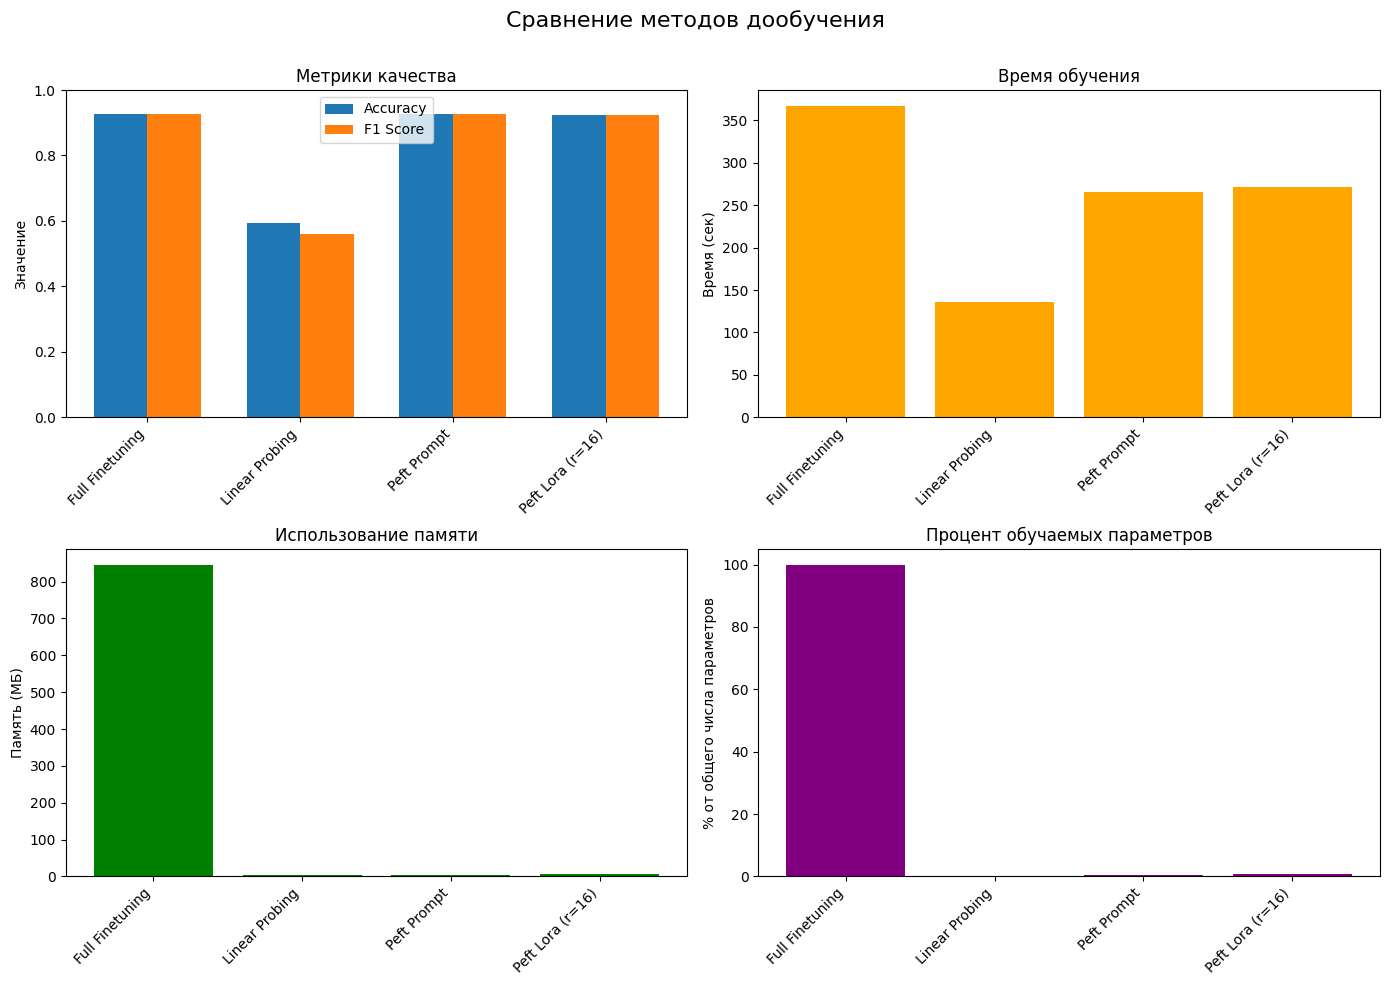

График сохранен в файл comparison_plots.png

--- Анализ результатов ---


## Сравнительный анализ методов

### 1. Качество классификации

Лучший результат по F1-метрике показал метод **Full Finetuning** со значением **0.9281**.

- По сравнению с методом **Linear Probing** улучшение составляет **0.3696** (или **66.17%**)
- По сравнению с методом **Peft Lora** улучшение составляет **0.0039** (или **0.42%**)
- По сравнению с методом **Peft Prompt** улучшение составляет **0.0013** (или **0.14%**)

### 2. Эффективность обучения

Самым быстрым оказался метод **Linear Probing** со временем обучения **135.92 секунд**.

- **Peft Prompt** медленнее на **129.45 секунд** (или **95.24%**)
- **Peft Lora** медленнее на **135.26 секунд** (или **99.51%**)
- **Full Finetuning** медленнее на **231.62 секунд** (или **170.41%**)

### 3. Эффективность использования параметров

Наименьшее количество обучаемых параметров у метода **Linear Probing**: **298,374** параметров (**0.2718%** от общего числа).

- **Peft Prompt** использует на **148,608** параметров больше (**49.81%**), что составляет **0.4066%** от общего числа
- **Peft Lora** использует на **590,976** параметров больше (**198.07%**), что составляет **0.8057%** от общего числа
- **Full Finetuning** использует на **109,188,480** параметров больше (**36594.50%**), что составляет **100.0000%** от общего числа

### 4. Общие выводы

1. По балансу качества и эффективности лучшим методом является **Peft Prompt**.
2. **Рекомендации по выбору метода:**
   - При ограниченных вычислительных ресурсах: **Linear Probing**
   - При ограниченном времени обучения: **Linear Probing**
   - При приоритете качества модели: **Full Finetuning**

4. **Full finetuning** значительно превосходит **Linear Probing** по качеству, что указывает на важность обновления весов базовой модели для этой задачи.

### Заключение

Выбор метода дообучения трансформерной модели должен основываться на балансе между качеством классификации, вычислительными ресурсами и временем обучения. В данном сравнении наилучший компромисс между этими факторами обеспечивает метод **Peft Prompt**.


Подробный анализ сохранен в файл results_analysis.md


In [19]:
results = combine_results(full_finetuning_results, linear_probing_results, peft_results, final_results)

print("\n--- Этап 6: Сравнительный анализ методов ---")

# Создаем сводную таблицу
table = create_comparison_df(results)
print("\n--- Сравнительная таблица результатов ---")
display(table)

# Визуализируем результаты
try:
    visualize_results(results)
except Exception as e:
    print(f"Ошибка при создании визуализации: {e}")

# Анализируем результаты
analysis = analyze_results(results)
print("\n--- Анализ результатов ---")
display(Markdown(analysis))

# Сохраняем результаты в текстовый файл
with open("results_analysis.md", "w", encoding="utf-8") as f:
    f.write(table.to_markdown(index=False) + "\n\n")
    f.write(analysis)

print("\nПодробный анализ сохранен в файл results_analysis.md")